In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import cv2
from glob import glob

from src.data.dataloader import DataGenerator
from src.helpers import setup_gpu

setup_gpu(0)

In [2]:
path = '/datasets/DIODO/val/indoors/'

filelist = []
for root, dirs, files in os.walk(path):
    for file in files:
        filelist.append(os.path.join(root, file))
filelist.sort()
data = {
    "image": [x for x in filelist if x.endswith(".png")],
    "depth": [x for x in filelist if x.endswith("_depth.npy")],
    "mask":  [x for x in filelist if x.endswith("_depth_mask.npy")],
}
df = pd.DataFrame(data)
df = df.sample(frac=1, random_state=50)

loader = DataGenerator(
    data=df[:128].reset_index(drop="true"),
    batch_size=16,
    dim=[256,256])

In [3]:
ib, lb = next(iter(loader))

2022-11-13 12:09:26.255440: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-13 12:09:26.256843: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 12:09:26.257077: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 12:09:26.257250: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [4]:
lb.max()

2.6952359676361084

In [18]:
# images_path= glob('/datasets/DIODO/val/indoors/scene_00019/scan_00183/00019_00183_indoors_000_010.png')
# depth_path = glob('/datasets/DIODO/val/indoors/scene_00019/scan_00183/00019_00183_indoors_000_010_depth.npy')
# masks_path = glob('/datasets/DIODO/val/indoors/scene_00019/scan_00183/00019_00183_indoors_000_010_depth_mask.npy')
images_path= sorted(glob('/datasets/DIODO/val/*/*/*/*.png'))
depth_path = sorted(glob('/datasets/DIODO/val/*/*/*/*_depth.npy'))
masks_path = sorted(glob('/datasets/DIODO/val/*/*/*/*_depth_mask.npy'))

In [ ]:
# def load(self, image_path, depth_map, mask):
#     """Load input and target image."""

#     image_ = cv2.imread(image_path)
#     image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)
#     image_ = cv2.resize(image_, self.dim)
#     image_ = tf.image.convert_image_dtype(image_, tf.float32)

#     depth_map = np.load(depth_map).squeeze()

#     mask = np.load(mask)
#     mask = mask > 0

#     max_depth = min(300, np.percentile(depth_map, 99))
#     depth_map = np.clip(depth_map, self.min_depth, max_depth)
#     depth_map = np.log(depth_map, where=mask)

#     depth_map = np.ma.masked_where(~mask, depth_map)

#     depth_map = np.clip(depth_map, 0.1, np.log(max_depth))
#     depth_map = cv2.resize(depth_map, self.dim)
#     depth_map = np.expand_dims(depth_map, axis=2)
#     depth_map = tf.image.convert_image_dtype(depth_map, tf.float32)

#     return image_, depth_map

(768, 1024, 3)
(768, 1024, 1)
(768, 1024)
Depth
0.0 197.55577


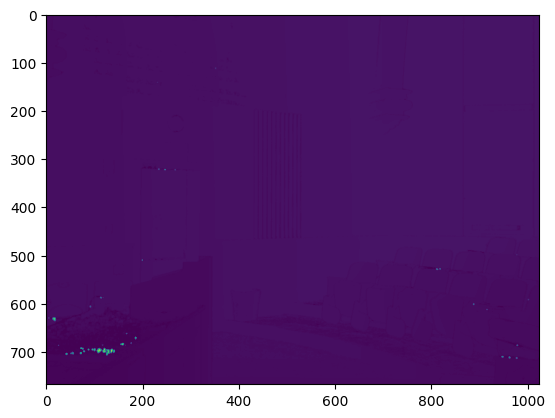

Mask
0.0 1.0


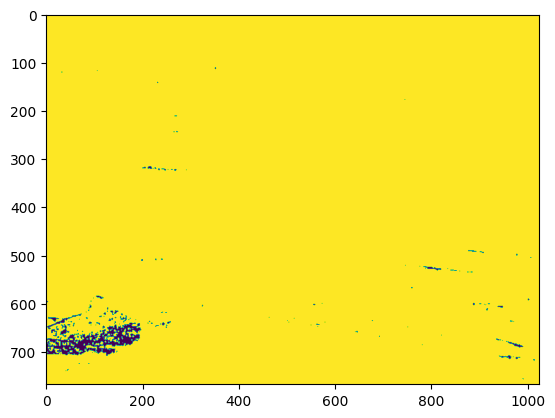

In [28]:
idx = 0
image = cv2.imread(images_path[idx])
depth = np.load(depth_path[idx])
mask  = np.load(masks_path[idx])

print(image.shape)
print(depth.shape)
print(mask.shape)

print('Depth')
print(depth.min(), depth.max())


plt.imshow(  depth / depth.max() )
plt.show()

print('Mask')
print(mask.min(), mask.max())

plt.imshow(mask)
plt.show()

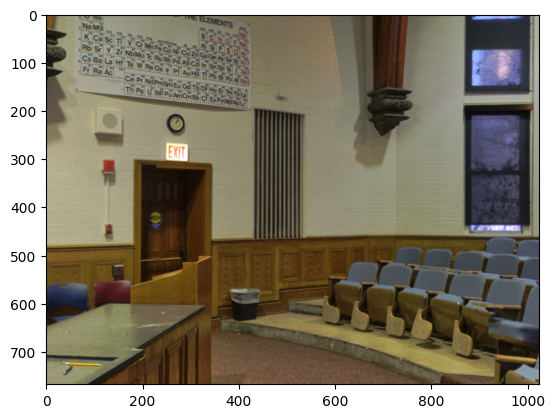

In [11]:
image = cv2.imread(images_path[0])
plt.imshow(image[:,:,::-1])
plt.show()

In [26]:
depth[0,0]

array([6.7121954], dtype=float32)

In [27]:
np.log(depth)[0,0]

/tmp/ipykernel_381902/97847518.py:1: RuntimeWarning: divide by zero encountered in log
  np.log(depth)[0,0]


array([1.9039261], dtype=float32)

In [24]:
np.percentile(depth, 99)

10.370360078811645

# Data preparation

In [31]:
import pandas as pd

In [39]:
validation_df = pd.read_csv('/workspace/tmp/DIODO_val.csv')

# Dataloader

In [29]:
import tensorflow as tf

In [ ]:
def read_image(image_path):
    content = tf.io.read_file(image_path)
    ext = tf.strings.split(image_path, '.')[-1]
    ext = tf.strings.lower(ext)

    bmp_decode  = lambda: tf.image.decode_bmp(content, channels=3)
    png_decode  = lambda: tf.image.decode_png(content, channels=3)
    jpeg_decode = lambda: tf.image.decode_jpeg(content, channels=3, try_recover_truncated=True)

    image = tf.case([ (ext == tf.constant('bmp'), bmp_decode),
                    (ext == tf.constant('png'), png_decode),
                    (ext == tf.constant('jpg'), jpeg_decode),
                    (ext == tf.constant('jpeg'), jpeg_decode),
                  ], default=bmp_decode)
    image = tf.image.convert_image_dtype(image, dtype='float32') #will be in [0, 1]
    return image

def load_images(filenameA, filenameB):
    return read_image(filenameA), read_image(filenameB)

def build_tf_dataset_dataloader(input_paths, target_paths, batch_size=32, transforms=[], train=True):
    data = tf.data.Dataset.from_tensor_slices( (input_paths, target_paths) )
    if train:
        data = data.shuffle(1024)

    for transform_f in transforms:
        data = data.map(transform_f, num_parallel_calls=tf.data.AUTOTUNE)
    data = data.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
    return data